#### Question 1

Posted on absalon is a press release from the European Securities and Markets Authoriy regarding its decision to prohibit sales of binary options to retail investors. Read the [article](https://www.esma.europa.eu/press-news/esma-news/esma-agrees-prohibit-binary-options-and-restrict-cfds-protect-retail-investors) and answer the following questions:

1. What is the motivation behind this decision? How does this relate to the models we have seen in class?

2. What eﬀect will this decision have on liquidity in the binary options market?

3. Measures announced in the press release diﬀer between the binary option and CFD markets. How will the eﬀects of the regulation be diﬀerent across the two markets?

Be concise and to the point. Please try to keep your answer less than 100 words (but not just one sentense).

1. The motivation is to protect retail investors. In the model we seen in class, informed investors earn money and uninformed investors lose money. The decision to prohibit binary options and restrict CFDs aims to protect retail investors from significant losses due to the complexity, lack of transparency, excessive leverage, and inherent conflicts of interest in these products.
2. It will decrease liquidity in the binary options market and retail investors will no longer be able to participate and the market depth will be small.
3. Complete prohibition for binary options and restrictions for CFDs, including leverage limits and negative balance protection, will likely reduce the appeal of binary options entirely, while the CFD market may see reduced trading volumes.

#### Question 2 Trade data 
In the following use the trade data in tqBAC.csv.  Denote trade prices by $p_t$ and mid-quotes by $m_t$.
* Sign each trade based on Lee-ready algorithm 
* Calcualte Spread, Effective Spread and Realized Spread by EXCHANGES
* Examine order correlation 

#### Import the relevant modules

In [1]:
### In this project, I will use datatable (quicker) rather pandas to manipulate data. You can see which one is more intuitive for you 
from datetime import datetime
import datatable as dt
from datatable import dt, f, by, update
import statsmodels.formula.api as smf
import numpy as np
import matplotlib.pyplot as pl
import os
import pandas as pd
data = pd.read_csv('/Users/yiyujie/Desktop/program/Trading, Market Frictions, and FinTech/tqBAC.csv')
data['date'] = data['date'].apply(lambda x : x[:-1]+'.000Z' if len(x)==20 else x)
data['date'] = pd.to_datetime(data['date'])

#### Lee and Ready algorithm 
A typical classification is 
 *   buyer-initiated  if pt > mt
 *   buyer-initiated  if pt = mt and pt > pt−1 (downtick)
 *   seller-initiated if pt < mt
 *   seller-initiated if pt = mt and pt < pt−1 (uptick)

In [2]:
data['mid_quotes'] = (data['BID'] + data['OFR']) / 2
data['price_diff'] = data['PRICE'].diff()
# +1 for buy, -1 for sell
data['class'] = data.apply(lambda x: 1 if ((x['PRICE'] > x['mid_quotes']) | ((x['PRICE'] == x['mid_quotes']) & (x['price_diff'] > 0))) else (-1 if (x['PRICE'] < x['mid_quotes']) | ((x['PRICE'] == x['mid_quotes']) & (x['price_diff'] < 0)) else 0), axis=1)
data['class']

0       -1
1       -1
2       -1
3        1
4       -1
        ..
24455    1
24456    1
24457   -1
24458    1
24459   -1
Name: class, Length: 24460, dtype: int64

#### Calcualte Spread, Effective Spread and Realized Spread by EXCHANGES
Note that for realized spread, using mid-quote in 10 mins 
1. calcate correlation of three spreads
2. plot time series of three spreads by hour 
2. calcuate mean spreads at the Exchange level 

EXCHANGES:P's spreads' correlation: 
                     spreads  spreads_effective  spreads_realized
spreads            1.000000          -0.106888         -0.010547
spreads_effective -0.106888           1.000000          0.006803
spreads_realized  -0.010547           0.006803          1.000000 

EXCHANGES:P's mean spreads: 
spreads: 0.010774710596616164 
spreads_effective: 0.0013312555654493381 
spreads_realized -0.006065573770492351 

EXCHANGES:T's spreads' correlation: 
                     spreads  spreads_effective  spreads_realized
spreads            1.000000          -0.024864         -0.090221
spreads_effective -0.024864           1.000000          0.083840
spreads_realized  -0.090221           0.083840          1.000000 

EXCHANGES:T's mean spreads: 
spreads: 0.01098412698412701 
spreads_effective: 8.25396825394992e-05 
spreads_realized -0.012328910614525547 

EXCHANGES:N's spreads' correlation: 
                     spreads  spreads_effective  spreads_realized
spreads      

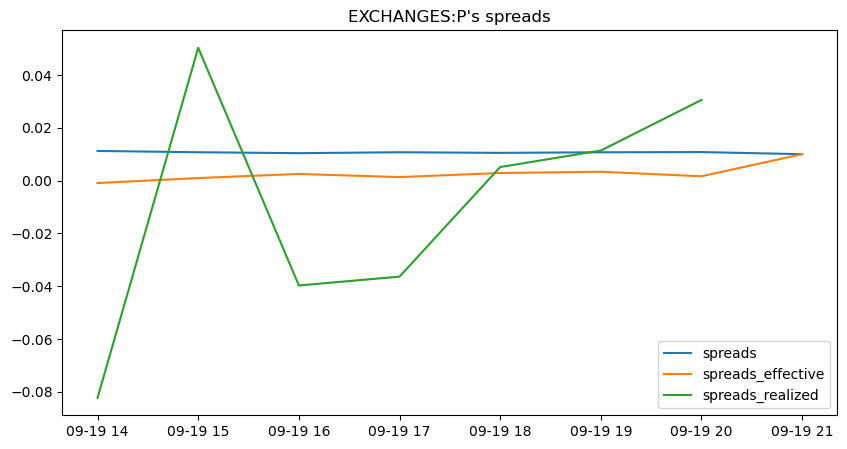

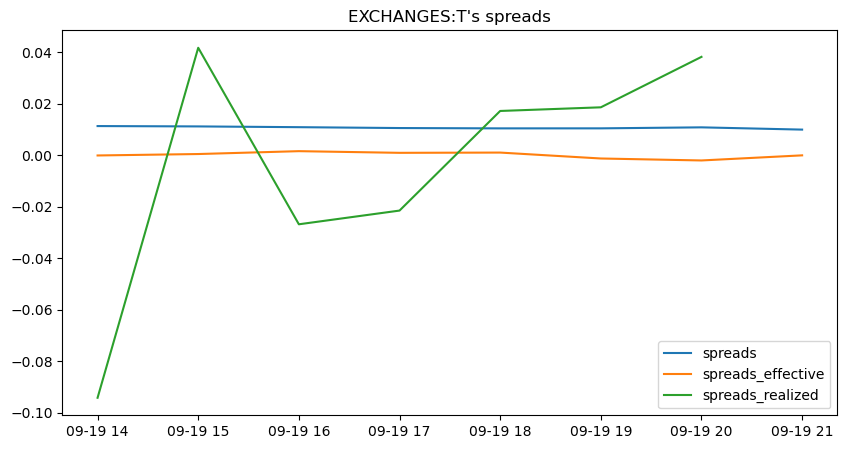

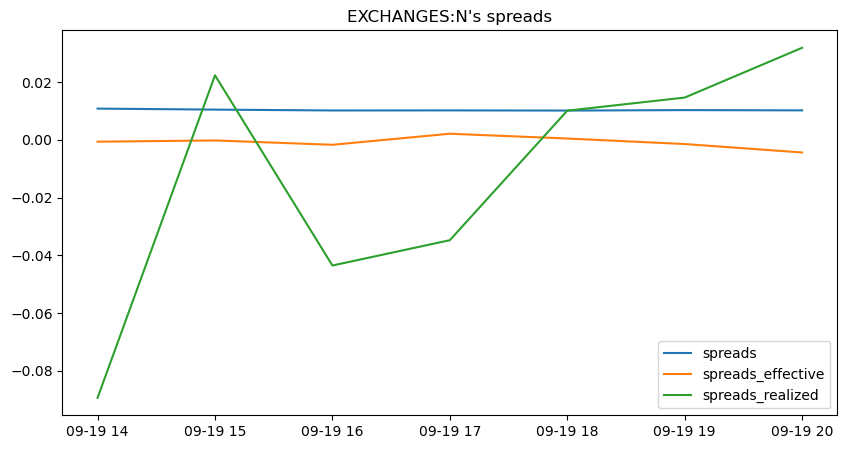

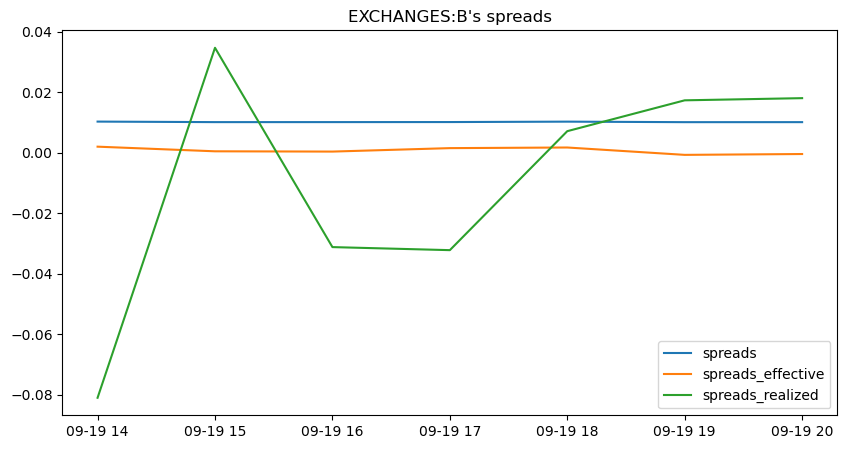

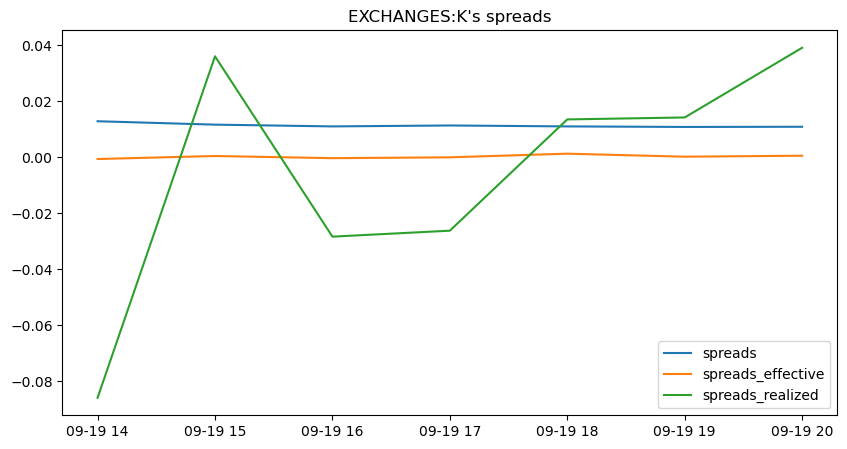

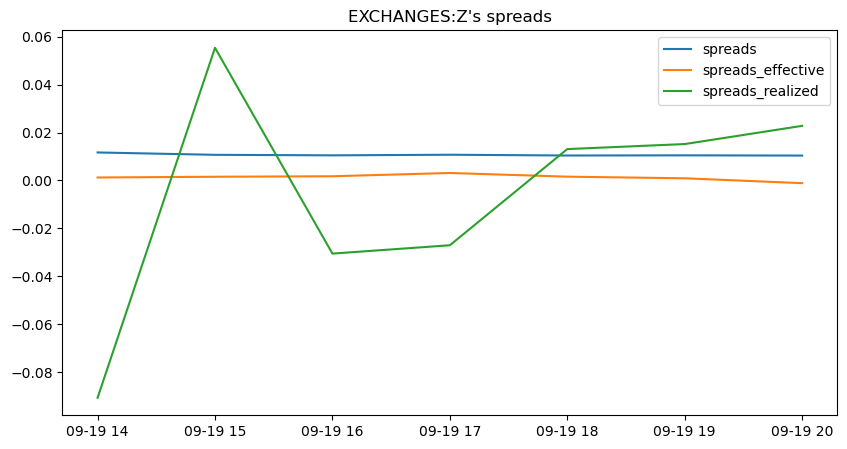

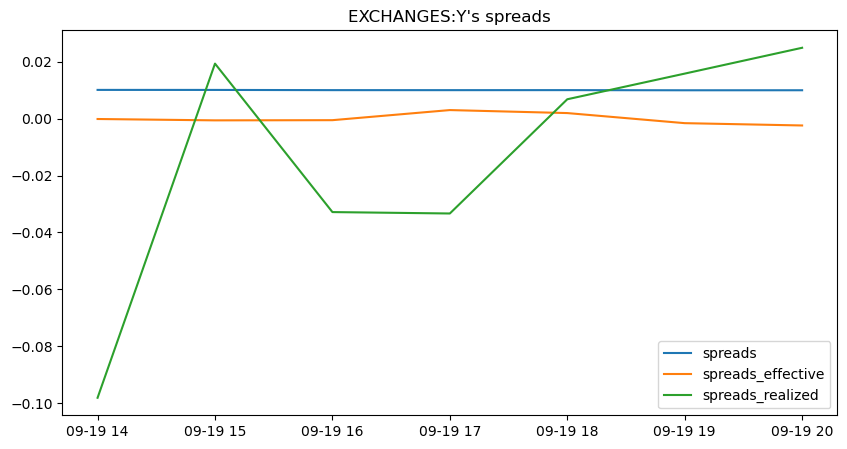

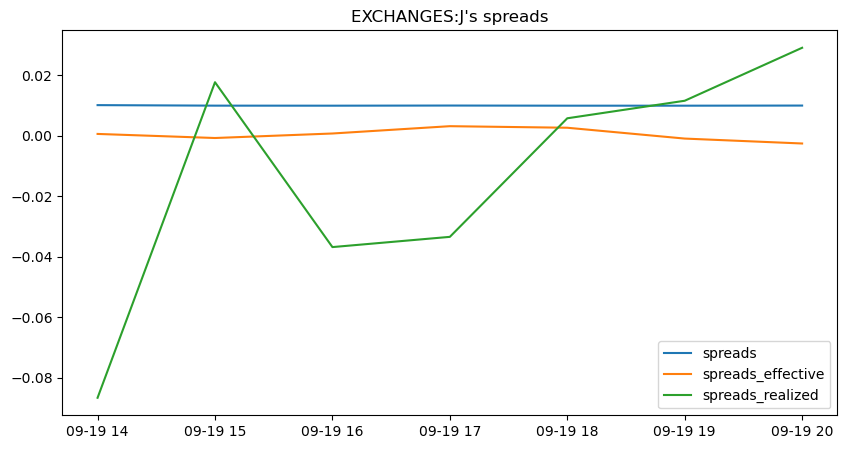

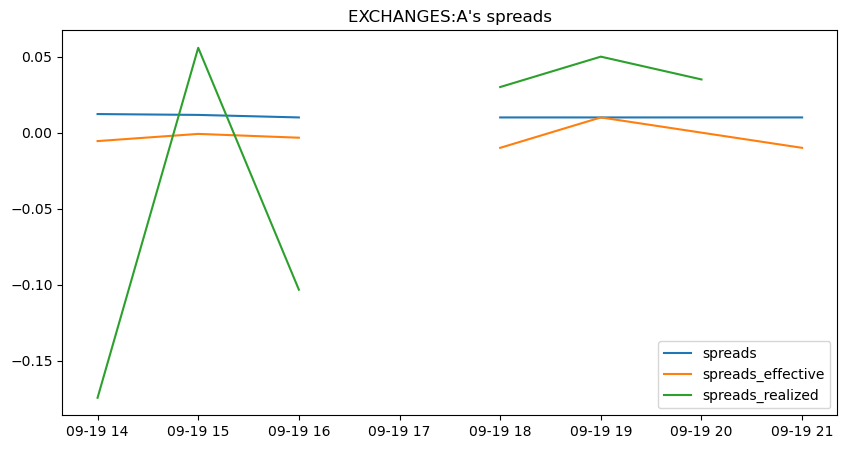

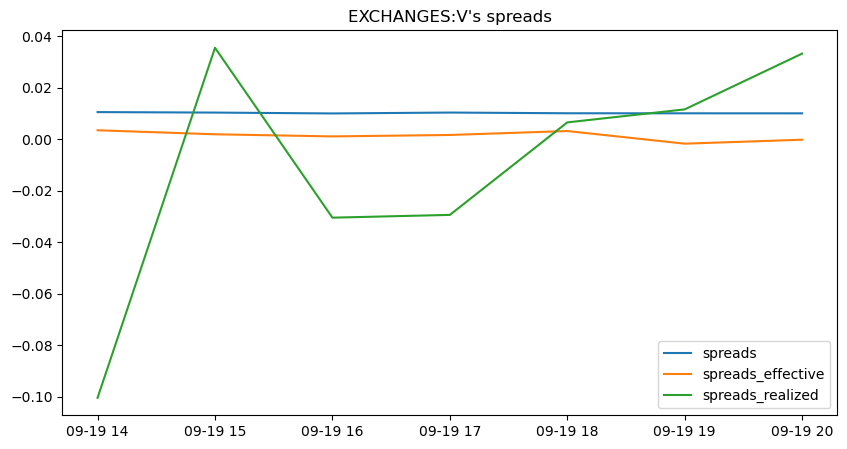

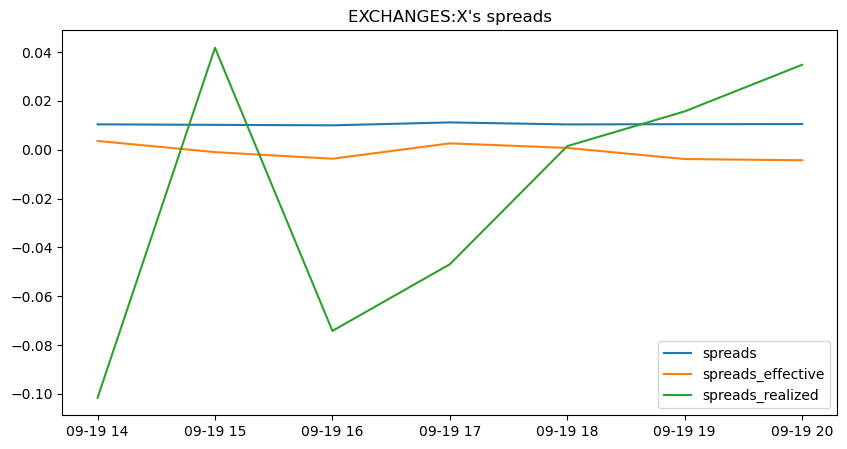

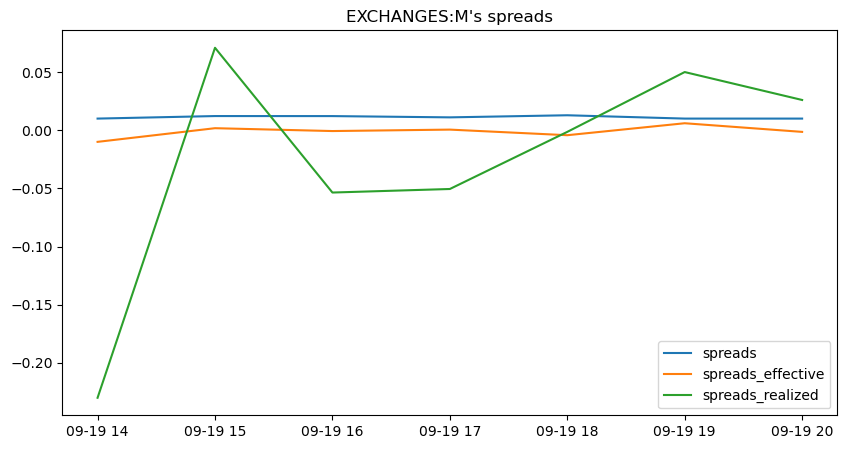

In [3]:
data['spreads'] = data['OFR'] - data['BID']
data['spreads_effective'] = (data['PRICE'] - data['mid_quotes']) * 2
Spreads_Realized = {}
for ex in data['EX'].unique():
    w = data[data['EX']==ex].set_index('date')
    w['FutureTime'] = w.index + pd.Timedelta(minutes=10)
    merged_data = pd.merge_asof(w, w[['mid_quotes']].rename(columns={'mid_quotes': 'Future_mid_quotes'}),
                            left_on='FutureTime', right_index=True, direction='forward')
    merged_data['spreads_realized'] = 2 * (merged_data['PRICE'] - merged_data['Future_mid_quotes'])
    Spreads_Realized[ex] = merged_data['spreads_realized']
    print("EXCHANGES:"+ex+"'s spreads' correlation:",'\n',
          pd.concat([data[data['EX']==ex].set_index('date')['spreads'],
                     data[data['EX']==ex].set_index('date')['spreads_effective'],
                     merged_data['spreads_realized']],axis=1).corr(),'\n')
    plt.figure(figsize=(10, 5))
    plt.plot(data[data['EX']==ex].set_index('date')['spreads'].resample('h').mean(),label='spreads')
    plt.plot(data[data['EX']==ex].set_index('date')['spreads_effective'].resample('h').mean(),label='spreads_effective')
    plt.plot(merged_data['spreads_realized'].resample('h').mean(),label='spreads_realized')
    plt.legend()
    plt.title("EXCHANGES:"+ex+"'s spreads")
    print("EXCHANGES:"+ex+"'s mean spreads:",'\nspreads:',data[data['EX']==ex]['spreads'].mean(),
          '\nspreads_effective:',data[data['EX']==ex]['spreads_effective'].mean(),
          '\nspreads_realized',merged_data['spreads_realized'].mean(),'\n')


#### Order Sign Correlation
1. autocorrelation plot of order sign 
2. re-produce the above figure in log term (both x-axis and y-axis are in log term)

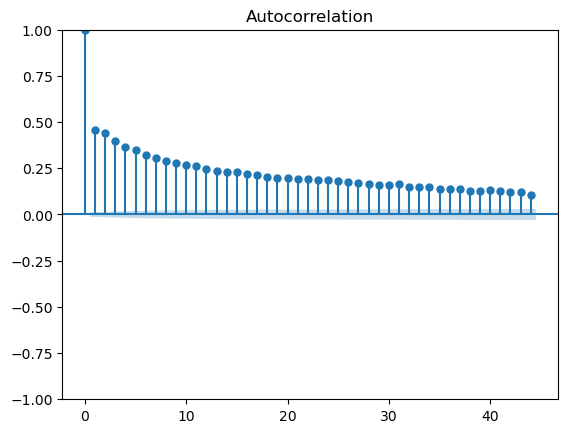

In [4]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(data['class'])
plt.show()

Text(0.5, 1.0, 'Autocorrelation of Order Signs in Log Scale')

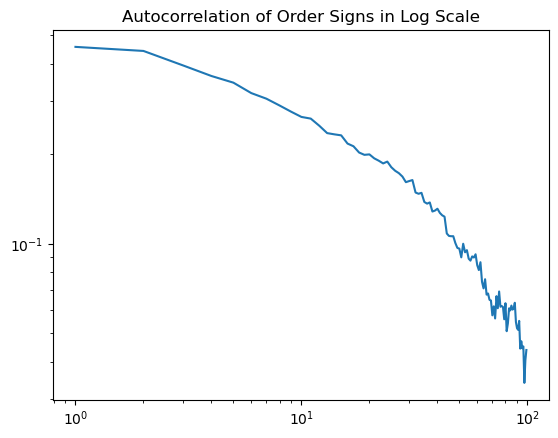

In [5]:
lags = range(1, 100)
autocorrs = [data['class'].autocorr(lag=lag) for lag in lags]
plt.plot(lags, autocorrs)
plt.xscale('log')
plt.yscale('log')
plt.title('Autocorrelation of Order Signs in Log Scale')

#### Question 3 Quote data
Data BAC_nbbo.csv is order bood data (only the best quotes), with each row one of the price or size at the best bid or ask changes which corresponds to change in the supply or demand. 
* Calculate order imbalance OFI (keep only Nasdaq exchanges)
* Aggregate OFI to second level (take summation)

##### Order Imbalance
Order flow imbalance represents the changes in supply and demand. 
* Best bid or size at the best bid increase -> increase in demand.
* Best bid or size at the best bid decreases -> decrease in demand.
* Best ask decreases or size at the best ask increases -> increase in supply.
* Best ask increases or size at the best ask decreases -> decrease in supply.

Mathematically we summarise these four effects at from time $n-1$ to $n$ as:
$$e_n = I_{B_n \geq B_{n-1}} q_n - I_{B_n \leq B_{n-1}} q_{n-1} - I_{A_n \leq A_{n-1}} q_n + I_{A_n \geq A_{n-1}} q_{n-1} $$
where $B_n$ is the beset Bid price at time $n$ and $q_n$ is the size at those prices 

In [10]:
BAC_nbbo = pd.read_csv('/Users/yiyujie/Desktop/program/Trading, Market Frictions, and FinTech/BAC_nbbo.csv')

/var/folders/l_/m6g3497s5j77bqb9jr7506tc0000gn/T/ipykernel_42505/1333732269.py:1: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  BAC_nbbo = pd.read_csv('/Users/yiyujie/Desktop/program/Trading, Market Frictions, and FinTech/BAC_nbbo.csv')


In [11]:
# Creat second stamp
BAC_nbbo['DATE_TIME'] = pd.to_datetime(BAC_nbbo['DATE'].astype(str) + ' ' + BAC_nbbo['TIME_M'])

In [12]:
## only keep trading hours
BAC_nbbo = BAC_nbbo.set_index('DATE_TIME')
BAC_nbbo = BAC_nbbo.between_time('09:30:00', '16:00:00')

In [13]:
# notice the extreme values in BID and ASK!! 
# need to clean data 
# first, remove negative spreads
BAC_nbbo = BAC_nbbo[BAC_nbbo['ASK'] >= BAC_nbbo['BID']]
# then outlier quotes
BAC_nbbo = BAC_nbbo[(BAC_nbbo['BID'] >= BAC_nbbo['BID'].quantile(0.01)) & (BAC_nbbo['BID'] <= BAC_nbbo['BID'].quantile(0.99)) &
                  (BAC_nbbo['ASK'] >= BAC_nbbo['ASK'].quantile(0.01)) & (BAC_nbbo['ASK'] <= BAC_nbbo['ASK'].quantile(0.99))]

In [14]:
# Aggregate by second 
# Construct return as log difference of last mid price and first mid price of each second 
BAC_nbbo = BAC_nbbo[BAC_nbbo['EX']=='N']
BAC_nbbo['mid_quotes'] = (BAC_nbbo['BID'] + BAC_nbbo['ASK']) / 2
BAC_nbbo['OFI'] = (BAC_nbbo['BID'].diff()>=0).astype(int) * BAC_nbbo['BIDSIZ'] - (BAC_nbbo['BID'].diff()<=0).astype(int) * BAC_nbbo['BIDSIZ'].shift(1) - (BAC_nbbo['ASK'].diff()<=0).astype(int) * BAC_nbbo['ASKSIZ'] + (BAC_nbbo['ASK'].diff()>=0).astype(int) * BAC_nbbo['ASKSIZ'].shift(1)
OFI = BAC_nbbo.resample('s')['OFI'].sum().dropna()
return_log = BAC_nbbo['mid_quotes'].resample('s').apply(lambda x: np.log(x.iloc[-1]/x.iloc[0]) if not x.empty else np.nan).rename('return').dropna()

Using OFI to generate trading signal: first do train/test split by selecting the first 70% of the data

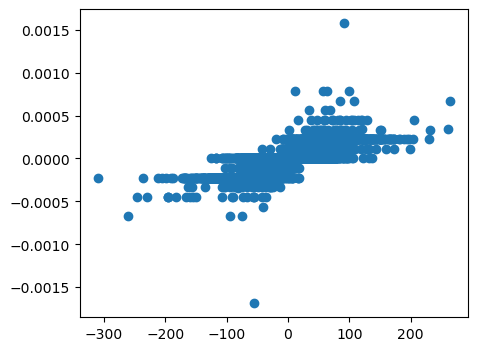

In [15]:
ofi_return = pd.merge(OFI,return_log,how='right',left_index=True,right_index=True)
train_df = ofi_return.iloc[:int(len(ofi_return) * 0.7)]
test_df = ofi_return.iloc[int(len(ofi_return) * 0.7):]
plt.figure(figsize=(5, 4))
plt.scatter(train_df['OFI'],train_df['return'])

In [16]:
model = smf.ols(formula='Q("OFI") ~ Q("return")', data=train_df).fit()
summary = model.summary()
print(summary)

                            OLS Regression Results                            
Dep. Variable:               Q("OFI")   R-squared:                       0.458
Model:                            OLS   Adj. R-squared:                  0.458
Method:                 Least Squares   F-statistic:                 1.181e+04
Date:                Tue, 20 Feb 2024   Prob (F-statistic):               0.00
Time:                        23:11:29   Log-Likelihood:                -64378.
No. Observations:               13979   AIC:                         1.288e+05
Df Residuals:                   13977   BIC:                         1.288e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       0.1524      0.205      0.745      

In [18]:
# explainatry power for test sample 
from sklearn.metrics import mean_squared_error
y_pred = model.predict(test_df)
mse = mean_squared_error(test_df['return'], y_pred)
print("Mean Squared Error (MSE):", mse)

Mean Squared Error (MSE): 253.66973955538023


##### Construct a Predictive Trading Signal
BUT! The above analysis is in-sample. We want to see out-sample results. 

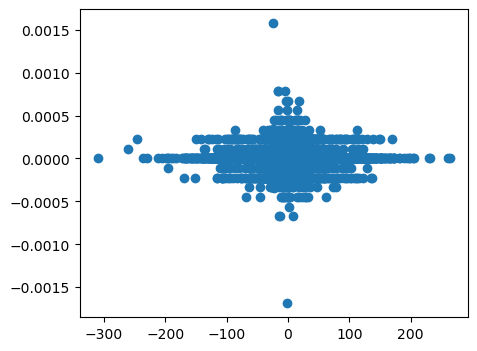

In [19]:
# calculate one-second ahead return 
ofi_return['future_return'] = ofi_return['return'].shift(-1)
ofi_return['lagged_ofi'] = ofi_return['OFI'].shift(1)
ofi_return = ofi_return[1:-1]
train_df = ofi_return.iloc[:int(len(ofi_return) * 0.7)]
test_df = ofi_return.iloc[int(len(ofi_return) * 0.7):]
plt.figure(figsize=(5, 4))
plt.scatter(train_df['lagged_ofi'],train_df['future_return'])

In [20]:
# Test whether OFI can explain FUTURE return variations
# Split sample to test and train samples again 
# Test whether lagged OFI can predict FUTURE return
model = smf.ols(formula='Q("OFI") ~ Q("future_return")', data=ofi_return).fit()
summary = model.summary()
print(summary)
model = smf.ols(formula='Q("lagged_ofi") ~ Q("future_return")', data=ofi_return).fit()
summary = model.summary()
print(summary)

                            OLS Regression Results                            
Dep. Variable:               Q("OFI")   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     24.69
Date:                Tue, 20 Feb 2024   Prob (F-statistic):           6.79e-07
Time:                        23:12:16   Log-Likelihood:            -1.0027e+05
No. Observations:               19968   AIC:                         2.006e+05
Df Residuals:                   19966   BIC:                         2.006e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              0.1837      0

In [21]:
# explainatry power for test sample
y_pred = model.predict(test_df)
mse = mean_squared_error(test_df['future_return'], y_pred)
print("Mean Squared Error (MSE):", mse)

Mean Squared Error (MSE): 0.2573927250325491


Text(0, 0.5, 'cummulative return')

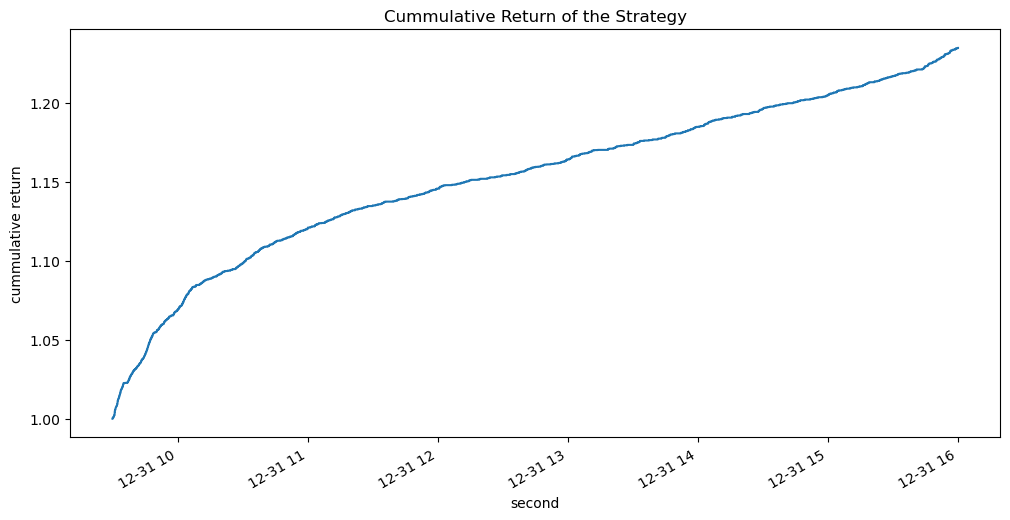

In [22]:
# plots cummulative return of the strategy using signal from past OFI 
ofi_return['model'] = model.predict(ofi_return)
cumulative_return = np.cumprod(1 + (ofi_return['model']>0)*ofi_return['future_return'])
plt.figure(figsize=(12, 6))
cumulative_return.plot()
plt.title('Cummulative Return of the Strategy')
plt.xlabel('second')
plt.ylabel('cummulative return')